**Optical Character Recognition(OCR) using DL**

**Table of Contents**

1. Importing Libraries
2. Helper Functions & Hyperparameters
3. Reading and preparing thr dataset
4. Modeling
5. Evaluation & Comparison
6. Post-processing
7. Concludion


**1. Importing Libraries**

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

**2. Helper Functions & Hyperparameters**



*   This section is used to deffine all Helper functions through the notebook and any hyperparameters used later for training models.



In [6]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hierarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-

    path: String -> the main folder directory that contains train/test folders

    ________________________________________________________________________________________________
    Return-

    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])

    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:

    path: String -> a directory of the image
    _____________________________________________________________
    Return:

    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:

    img: numpy.array of N-D

    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:

    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]



In [7]:
# Pre-defined Hyperparameters
IMG_SHAPE = (32, 32)
IMG_SIZE = (32, 32, 3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss='categorical_crossentropy'
EPOCHS = 10

Now we will use the Kaggle API to download the dataset to the system. First, we will require the API key. To do this just navigate to the profile section in Kaggle and download the JSON file containing your details for API, after that just upload this to colab or locate in the local Jupyter environment.

In [ ]:
# Install Kaggle module
! pip install Kaggle

In [4]:
# Upload API details of json file to Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maulanarhodes","key":"2a7f51a03914b9b4080fc78e0789c976"}'}

In [5]:
# creating kaggle directory and moving the json files there
! mkdir ~/.kaggle
! mv ~/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat '/root/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
# Download the dataset
! kaggle datasets download -d harieh/ocr-dataset/

Dataset URL: https://www.kaggle.com/datasets/harieh/ocr-dataset/versions/
License(s): CC0-1.0
 95% 145M/153M [00:01<00:00, 138MB/s]
100% 153M/153M [00:01<00:00, 121MB/s]


Now we unzip the dataset into the desired folder.

In [7]:
! unzip ocr-dataset.zip -d /content/ocr-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2535.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2536.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2537.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2538.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2539.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_254.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2540.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2541.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2542.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2543.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2544.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2545.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2546.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2547.png  
  inflating: /content/ocr-dataset/dataset/y_L/Y_L_2548.png  
  inflating: /content/ocr-dataset/d

**3. Reading & Preparing the dataset**

In [8]:
# Reading the dataset in dataframe
main_path = '/content/ocr-dataset/dataset'
df = directory_to_df(main_path)

# Convert the dataset into df of two columns
df.head()


The number of samples found: 85199


,image,label
0,/content/ocr-dataset/dataset/a_L/A_L_1018.png,a
1,/content/ocr-dataset/dataset/a_L/A_L_1391.png,a
2,/content/ocr-dataset/dataset/a_L/A_L_371.png,a
3,/content/ocr-dataset/dataset/a_L/A_L_800.png,a
4,/content/ocr-dataset/dataset/a_L/A_L_3403.png,a


In [9]:
df['label'].value_counts()

,count
label,
e,3284
r,3284
a,3281
m,3281
n,3281
q,3279
u,3278
d,3277
i,3277


**3.1 Splitting the Dataframe**


*   The dataframe is splitted to get 70% of the dataset for training and 30% for testing.

*   The training set is splitted into training and validation to enhance the model training.



In [10]:
# Splitting for training & testing (70, 30, respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=41)
training_df = pd.concat((X_train, y_train), axis=1)
testing_df = pd.concat((X_test, y_test), axis=1)

In [11]:
# Splitting for training & validation (75, 25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=41)
training_df = pd.concat((X_train, y_train), axis=1)
validation_df = pd.concat((X_valid, y_valid), axis=1)

**3.2 Creating Generators**


*   The ImageDataGenerator is used for data augmentation, the augmentation is required since the OCR can work with different brightness which is not included in the dataset.

*   Also, it enhances the RAM usage



In [12]:
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [13]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

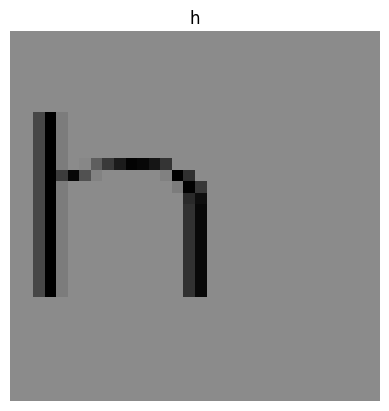

The shape of the image: (32, 32, 3)


In [14]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2   # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM], mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:', train_gen[BATCH_NUM][0][IMG_NUM].shape)

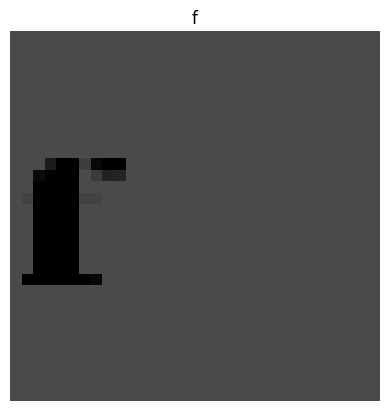

The shape of the image: (32, 32, 3)


In [15]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30   # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:', train_gen[BATCH_NUM][0][IMG_NUM].shape)

**4. Modeling**

Our target is to build a custom CNN model to train our targeted images for the OCR application. In advance, we also will use 4 Pre-trained models as part of Transfer Learning and to enhance the performance of the application.

Our targeted pretrained models are the following:

-EfficientNetB7

-MobileNetV2

-VGG19

-DenseNet121

The fine tuning strategy: using a small value of LR of the optimizer Adam will make an efficient use of the pre-trained models on our dataset without FREEZING the input layers in which better performance is required in our case.

**4.1 Custom CNN**

In [16]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [17]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 3)             │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 30, 30, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 10, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 256)             │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 8, 8, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 4, 4, 256)             │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 2, 2, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 2, 2, 512)             │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 1, 1, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1024)                  │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 26)                    │          26,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,621,038 (10.00 MB)

 Trainable params: 2,621,038 (10.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [19]:
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    # Changing the file extension to .keras
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [20]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1395/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4911 - loss: 2.0255
Epoch 1: val_loss improved from inf to 0.48344, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - accuracy: 0.4918 - loss: 2.0229 - val_accuracy: 0.8908 - val_loss: 0.4834 - learning_rate: 0.0010
Epoch 2/20
1393/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8816 - loss: 0.4344
Epoch 2: val_loss did not improve from 0.48344
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.8817 - loss: 0.4343 - val_accuracy: 0.8854 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 3/20
1395/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9060 - loss: 0.3412
Epoch 3: val_loss improved from 0.48344 to 0.37535, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9060 - loss: 0.3412 - val_accuracy: 0.9153 - val_loss: 0.3754 - learning_rate: 0.0010
Epoch 4/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9182 - loss: 0.30

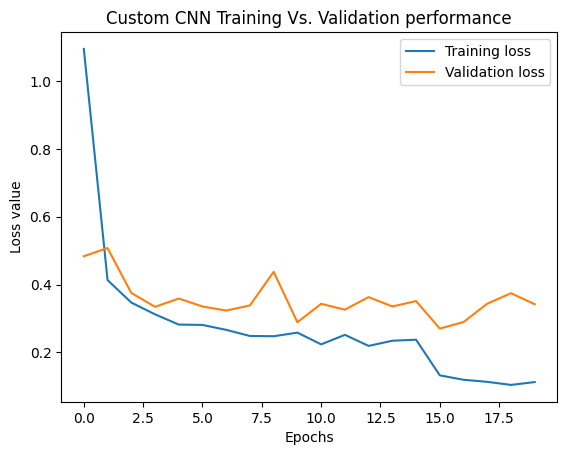

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training Vs. Validation performance")
plt.show()


In [22]:
# Making the prediction out of the Custom CNN for the training set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step


In [23]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.94      0.95      0.94      1010
           b       0.98      0.93      0.96       957
           c       0.90      0.96      0.93      1000
           d       0.96      0.95      0.95       986
           e       0.92      0.91      0.92       976
           f       0.97      0.93      0.95      1001
           g       0.94      0.95      0.95       998
           h       0.97      0.93      0.95      1015
           i       0.96      0.95      0.95       971
           j       0.95      0.98      0.96       933
           k       0.97      0.96      0.97       999
           l       0.89      0.97      0.93       979
           m       0.95      0.96      0.95       951
           n       0.92      0.94      0.93      1015
           o       0.92      0.96      0.94       951
           p       0.97      0.96      0.96       962
           q       0.96      0.95      0.

**4.2 EfficientNetB7**



In [24]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
EffNetB7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 1, 1, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,622,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,258,289 (256.57 MB)

 Trainable params: 66,947,562 (255.38 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [26]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


In [27]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EffNetB7"))

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1630 - loss: 3.0634
Epoch 1: val_loss improved from inf to 1.95810, saving model to EffNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 521s 212ms/step - accuracy: 0.1631 - loss: 3.0630 - val_accuracy: 0.4424 - val_loss: 1.9581 - learning_rate: 1.0000e-05
Epoch 2/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5626 - loss: 1.5301
Epoch 2: val_loss improved from 1.95810 to 1.26355, saving model to EffNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 151s 108ms/step - accuracy: 0.5626 - loss: 1.5300 - val_accuracy: 0.6457 - val_loss: 1.2635 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7075 - loss: 1.0337
Epoch 3: val_loss improved from 1.26355 to 0.72938, saving model to EffNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 165s 118ms/step - accuracy: 0.7075 - loss: 1.0336 - val_accuracy: 0.7963 - val_loss: 0.7294 - learning_rate: 1.0000e-05
Epoch 4/10
1398/

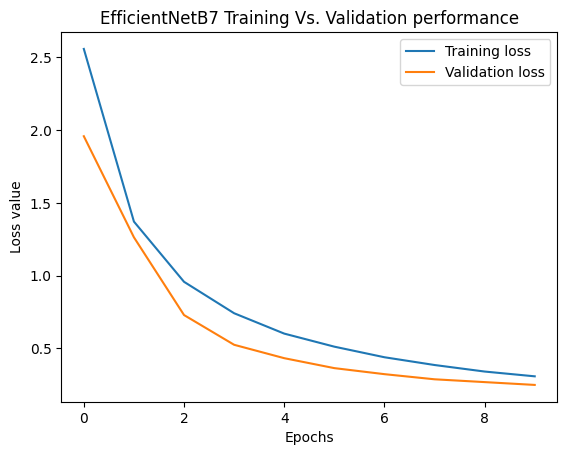

In [28]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training Vs. Validation performance")
plt.show()

In [29]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))


799/799 ━━━━━━━━━━━━━━━━━━━━ 61s 58ms/step


In [30]:
print('\t The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

	 The EfficientNetB7 Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.90      0.92      1010
           b       0.90      0.93      0.91       957
           c       0.92      0.91      0.91      1000
           d       0.95      0.94      0.95       986
           e       0.93      0.89      0.91       976
           f       0.94      0.93      0.93      1001
           g       0.88      0.92      0.90       998
           h       0.90      0.93      0.91      1015
           i       0.88      0.90      0.89       971
           j       0.94      0.95      0.95       933
           k       0.94      0.94      0.94       999
           l       0.89      0.93      0.91       979
           m       0.91      0.97      0.94       951
           n       0.94      0.91      0.92      1015
           o       0.91      0.96      0.93       951
           p       0.97      0.93      0.95       962
           q       0.95      0.94    

**4.3 MobileNetV2**

In [31]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

<ipython-input-31-623c609b2163>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
MobNetV2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,107,866 (15.67 MB)

 Trainable params: 4,073,754 (15.54 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [33]:
# Move the optimizer creation here, after the model is fully defined
opt = Adam(learning_rate=0.00001, epsilon=1e-6)  # Create the 'opt' optimizer after defining the model

MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [34]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0805 - loss: 3.9248
Epoch 1: val_loss improved from inf to 3.34832, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 107s 46ms/step - accuracy: 0.0805 - loss: 3.9245 - val_accuracy: 0.0683 - val_loss: 3.3483 - learning_rate: 1.0000e-05
Epoch 2/10
1396/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2423 - loss: 2.7728
Epoch 2: val_loss improved from 3.34832 to 2.65093, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.2424 - loss: 2.7725 - val_accuracy: 0.2517 - val_loss: 2.6509 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3478 - loss: 2.3028
Epoch 3: val_loss improved from 2.65093 to 2.04751, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.3478 - loss: 2.3028 - val_accuracy: 0.4072 - val_loss: 2.0475 - learning_rate: 1.0000e-05
Epoch 4/10
13

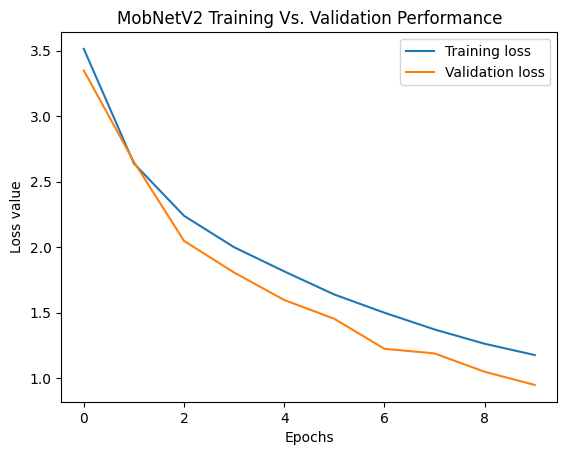

In [35]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobNetV2 Training Vs. Validation Performance")
plt.show()

In [36]:
# Making a prediction out of the MobileNetV2 ffor the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step


In [37]:
print('\t The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

	 The MobileNetV2 Evaluation Performance
              precision    recall  f1-score   support

           a       0.68      0.56      0.61      1010
           b       0.77      0.58      0.66       957
           c       0.65      0.67      0.66      1000
           d       0.66      0.65      0.66       986
           e       0.78      0.58      0.66       976
           f       0.79      0.58      0.67      1001
           g       0.65      0.81      0.72       998
           h       0.72      0.76      0.74      1015
           i       0.65      0.56      0.60       971
           j       0.66      0.84      0.74       933
           k       0.80      0.80      0.80       999
           l       0.66      0.82      0.73       979
           m       0.68      0.89      0.77       951
           n       0.59      0.64      0.61      1015
           o       0.68      0.81      0.74       951
           p       0.73      0.81      0.76       962
           q       0.65      0.66      0

**4.4 VGG19**

In [38]:
# VGG19 input layers wil not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
VG.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,087,834 (80.44 MB)

 Trainable params: 21,087,834 (80.44 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Create a new optimizer instance *after* defining the model
opt = Adam(learning_rate=0.00001, epsilon=1e-6)

# Compiling the model with the optimizer
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [41]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

Epoch 1/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6772 - loss: 1.4432
Epoch 1: val_loss improved from inf to 0.37649, saving model to VGG19_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 97s 63ms/step - accuracy: 0.6774 - loss: 1.4422 - val_accuracy: 0.9093 - val_loss: 0.3765 - learning_rate: 1.0000e-05
Epoch 2/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.2877
Epoch 2: val_loss improved from 0.37649 to 0.26067, saving model to VGG19_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 129s 57ms/step - accuracy: 0.9263 - loss: 0.2877 - val_accuracy: 0.9285 - val_loss: 0.2607 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9455 - loss: 0.1947
Epoch 3: val_loss improved from 0.26067 to 0.19850, saving model to VGG19_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.9455 - loss: 0.1947 - val_accuracy: 0.9471 - val_loss: 0.1985 - learning_rate: 1.0000e-05
Epoch 4/10
1398/1398 ━━━━━━━━━━

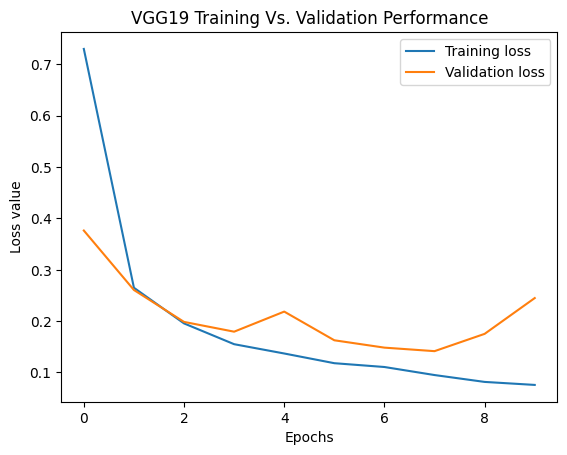

In [42]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training Vs. Validation Performance")
plt.show()

In [43]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step


In [44]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

		The VGG19 Evaluation Performance
              precision    recall  f1-score   support

           a       0.97      0.83      0.90      1010
           b       0.96      0.97      0.97       957
           c       0.99      0.88      0.93      1000
           d       0.99      0.96      0.97       986
           e       0.92      0.96      0.94       976
           f       0.98      0.97      0.97      1001
           g       0.88      0.96      0.92       998
           h       0.96      0.96      0.96      1015
           i       0.98      0.93      0.95       971
           j       0.95      0.98      0.97       933
           k       0.95      0.99      0.97       999
           l       0.93      0.96      0.94       979
           m       0.98      0.98      0.98       951
           n       0.94      0.97      0.95      1015
           o       0.97      0.96      0.97       951
           p       0.97      0.97      0.97       962
           q       0.82      0.99      0.90   

**4.5 DenseNet121**

In [45]:
# DenseNet121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
Den.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,625,242 (32.90 MB)

 Trainable params: 8,541,594 (32.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [47]:
# Create the optimizer affter defining the model
opt = Adam(learning_rate=0.00001, epsilon=1e-6)

# Compiling the model with the optimizer
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [48]:
hsitory5 = Den.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck("DenseNet121"))

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3096 - loss: 2.6241
Epoch 1: val_loss improved from inf to 0.83857, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 322s 126ms/step - accuracy: 0.3097 - loss: 2.6235 - val_accuracy: 0.7728 - val_loss: 0.8386 - learning_rate: 1.0000e-05
Epoch 2/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7483 - loss: 0.8819
Epoch 2: val_loss improved from 0.83857 to 0.46344, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 142s 62ms/step - accuracy: 0.7483 - loss: 0.8819 - val_accuracy: 0.8706 - val_loss: 0.4634 - learning_rate: 1.0000e-05
Epoch 3/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8323 - loss: 0.5889
Epoch 3: val_loss improved from 0.46344 to 0.33558, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 134s 56ms/step - accuracy: 0.8323 - loss: 0.5888 - val_accuracy: 0.9032 - val_loss: 0.3356 - learning_rate: 1.0000e-05
Epoch 4/10

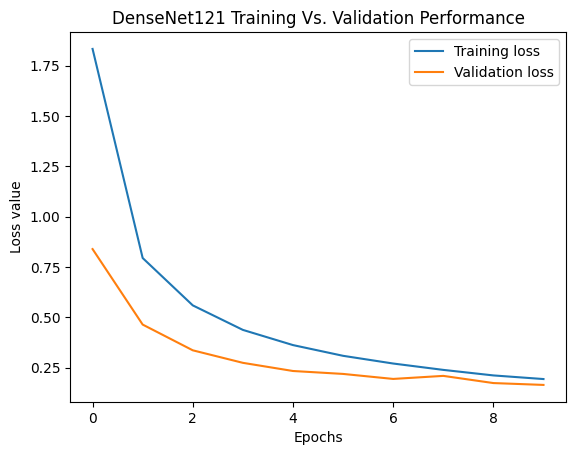

In [53]:
plt.plot(hsitory5.history['loss'], label='Training loss')
plt.plot(hsitory5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training Vs. Validation Performance")
plt.show()

In [54]:
# Making the prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step


In [55]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.96      0.95      1010
           b       0.93      0.96      0.94       957
           c       0.95      0.93      0.94      1000
           d       0.98      0.95      0.96       986
           e       0.93      0.93      0.93       976
           f       0.95      0.95      0.95      1001
           g       0.94      0.95      0.95       998
           h       0.95      0.95      0.95      1015
           i       0.91      0.98      0.94       971
           j       0.96      0.96      0.96       933
           k       0.96      0.95      0.96       999
           l       0.93      0.95      0.94       979
           m       0.95      0.97      0.96       951
           n       0.93      0.95      0.94      1015
           o       0.95      0.95      0.95       951
           p       0.97      0.97      0.97       962
           q       0.96      0.96      0

**5. Evaluation & Comparison**

In [56]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95], 'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.94,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN', 'EfficientNetB7', 'MobileNetV2', 'VGG19', 'DenseNet121'])
print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

		The Evaluation results of CNN/Pre-trained models
                accuracy  precision  recall  F1-Score
Custom CNN          0.95       0.96    0.95      0.95
EfficientNetB7      0.93       0.94    0.93      0.94
MobileNetV2         0.71       0.72    0.71      0.71
VGG19               0.96       0.96    0.96      0.96
DenseNet121         0.95       0.95    0.95      0.95


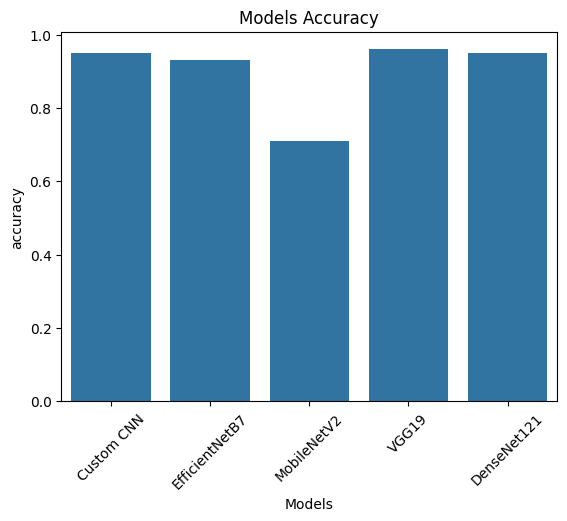

In [57]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

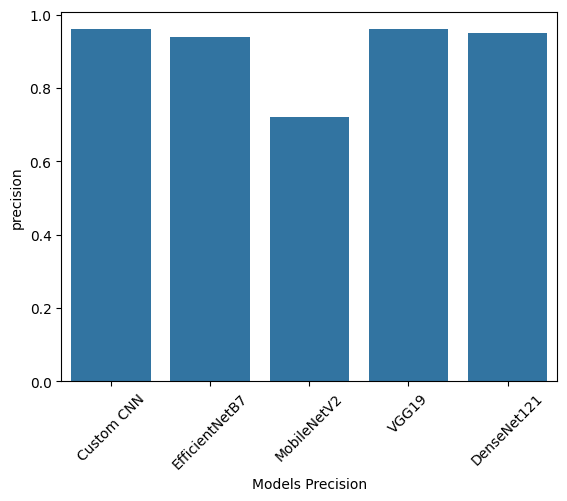

In [59]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel("Models Precision")
plt.show()

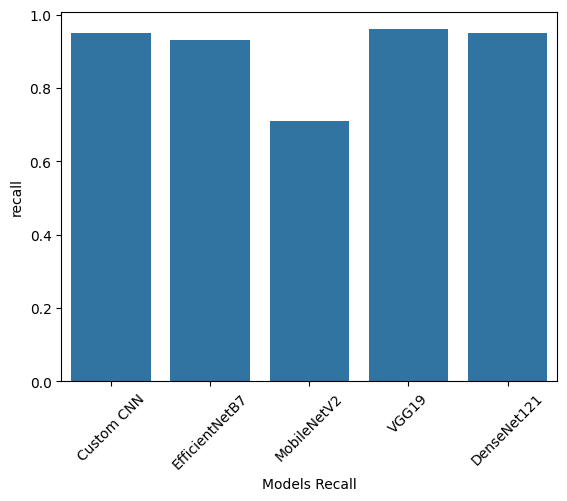

In [60]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel("Models Recall")
plt.show()

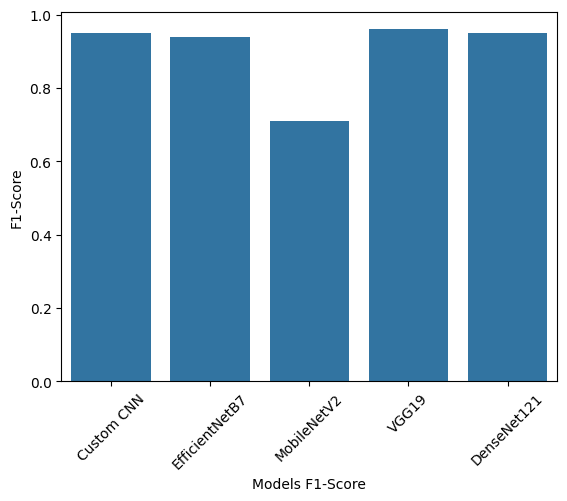

In [61]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel("Models F1-Score")
plt.show()

-VGG19 shows an outstanding performance amongst all models.

-Due to technical reasons in the next section Post-processing, it shows that DenseNet121 has better performance than VGG19 on external images, which will be used.

-The Custom CNN shows an excellent performance on the testing set on few number of epochs, it can be enhanced with more epochs and data augmentation.

**6. Post-Processing**

This section is about computer vision techniques.

The image will be takemn from the user/externally to be processed and input into our model. Some low level Computer Vision Techniques are used in order to enhance the input image, wjhetehr it is text or handwritten, these techniques are the following:

1. Binarization: The Binarization function uses Otsu's binarization to the grayscale image, producing a binary image.

2. Dilate: The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing words or characters.

3. Find Rectangles: The find_rect function identifies bounding rectangles in the binary image, sorting them based on their x-coordinate(From Left-to-Right)

4. Extract CHaracters: The extract function uses the aforementioned techniques to extract characters rom the image. It identifies words FIRST, then extracts characters rom each word, and with the use of the pre-trained deep learning model to recognize each character.

In [1]:
# Computer Vision - Low Level techniques
def load_model():
    model_path = 'content/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2>RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt) # Extract the bounding rectangle coordinates of each contour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the recvts ffrom Left-to-right
    return sorted-rects

def extract(image):
    model = load_model()
    chars = []  # a list to store recognized characters
    img_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)  # Recognized words within the image
    del _, bin_img, full_dil_img  # for better memory usage

    for word in words:
        x,y,w,h = word  # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])